In [56]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import cvxpy as cp

In [57]:
# Use past 10 years historical data
spy = pd.read_csv('SPY.csv')
agg = pd.read_csv('AGG.csv')

spy_log_ret = np.log(spy['Adj Close'] / spy['Adj Close'].shift(1))
agg_log_ret = np.log(agg['Adj Close'] / agg['Adj Close'].shift(1))

df_logret = pd.DataFrame({'stock' : spy_log_ret, 'bond' : agg_log_ret})
df_logret.loc[0, ['stock','bond']] = 0.0

In [58]:
# set parameter
_mu = df_logret.mean() * 251 
_sigma = df_logret.cov() * 251

mu = _mu.values.T
sigma = _sigma.values

num_samples = 10000
stock, bond = np.random.multivariate_normal(mu, sigma, num_samples).T

In [59]:
_mu

stock    0.118785
bond     0.013778
dtype: float64

In [60]:
_sigma

,stock,bond
stock,0.030746,0.000736
bond,0.000736,0.002644


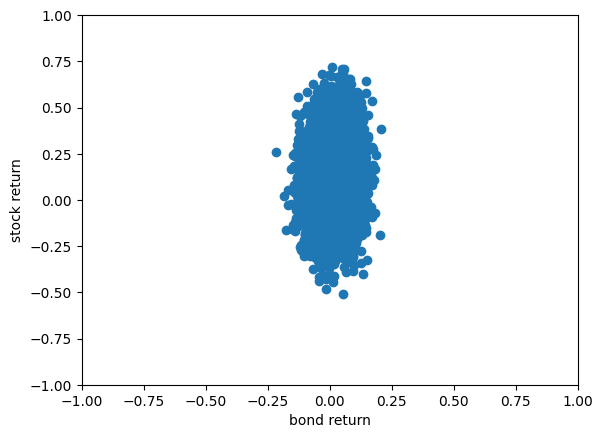

In [61]:
plt.scatter(bond, stock)
plt.xlabel('bond return')
plt.ylabel('stock return')
plt.xlim(-1,+1)
plt.ylim(-1,+1)
plt.show()

In [62]:
# cluster the performance for the simulated data
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters).fit(np.transpose([bond, stock]))

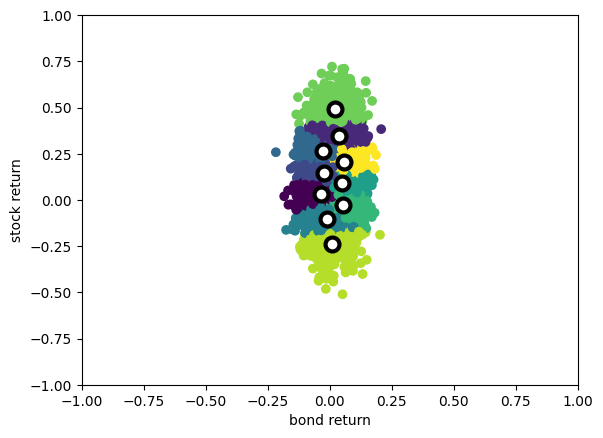

In [63]:
plt.scatter(bond, stock, c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, 
            color='white', edgecolors='black', linewidths=3)
plt.xlabel('bond return')
plt.ylabel('stock return')
plt.xlim(-1,+1)
plt.ylim(-1,+1)
plt.show()

In [64]:
print("Probability of each scenario")

prob = np.zeros(num_clusters)
for i in range(num_clusters):
    prob[i] = np.count_nonzero(kmeans.labels_==i)/num_samples
    print("cluster ", i, " : ", round(prob[i]*100,2), "%")

Probability of each scenario
cluster  0  :  12.25 %
cluster  1  :  10.51 %
cluster  2  :  12.84 %
cluster  3  :  9.93 %
cluster  4  :  9.32 %
cluster  5  :  13.55 %
cluster  6  :  9.99 %
cluster  7  :  4.51 %
cluster  8  :  4.7 %
cluster  9  :  12.4 %


In [65]:
scenarios = 1 + kmeans.cluster_centers_
scenarios

array([[0.9662175 , 1.03106388],
       [1.03575376, 1.34460952],
       [0.97628293, 1.14531603],
       [0.97433167, 1.2623872 ],
       [0.9874719 , 0.89412159],
       [1.05029649, 1.0895847 ],
       [1.05269387, 0.97263067],
       [1.02068176, 1.4906286 ],
       [1.0096377 , 0.76063579],
       [1.05767385, 1.207416  ]])

In [78]:
x_0 = cp.Variable(2)
y = cp.Variable(num_clusters)
w = cp.Variable(num_clusters)

q = 1
r = 10

init_amount = 100
goal_amount = 108

probability = cp.Problem(
    cp.Maximize(prob.T @ (q*y - r*w)),
    [
    sum(x_0) == init_amount,
    scenarios @ x_0 - y + w == goal_amount * np.ones(num_clusters),
    x_0 >= 0,
    y >= 0,
    w >= 0
    ]
)

probability.solve(solver=cp.ECOS)

-37.78006330856103

In [79]:
expected_return = (goal_amount + np.dot(prob, y.value - w.value)) / init_amount - 1
print("optimal allocation for stock = ", round(x_0.value[0],2), " bond = ", round(x_0.value[1],2))
print("expected_retun is ", round(100* expected_return, 2),"%")

optimal allocation for stock =  38.64  bond =  61.36
expected_retun is  7.94 %


Text(0, 0.5, 'final wealth')

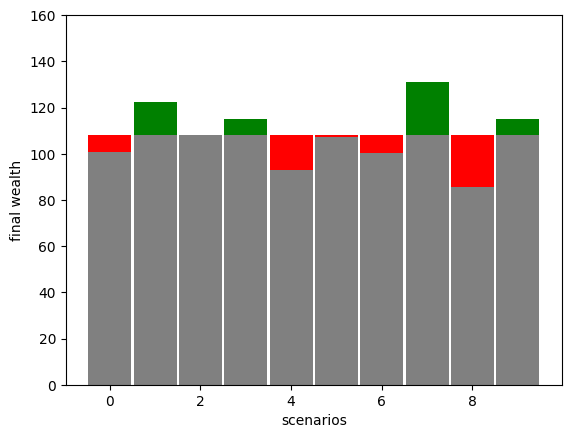

In [80]:
fix, ax = plt.subplots(1,1)
ax.bar(range(num_clusters), np.round(goal_amount+y.value,2), color='green', width=0.95)
ax.bar(range(num_clusters), goal_amount, color='red', width=0.95)
ax.bar(range(num_clusters), np.round(goal_amount-w.value,2), color='grey', width=0.95)
ax.set_ylim([0, 160])
ax.set_xlabel('scenarios')
ax.set_ylabel('final wealth')